In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# import umap
import umap.umap_ as umap
from collections import defaultdict

from scipy import linalg, spatial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)

from sklearn.utils.extmath import randomized_svd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [5]:
filename =  '/Users/angky/Cornell/AML/AML-Project/clustered_books.csv'
df = pd.read_csv(filename)
print(df.head(10))

                     title                                        description  \
0  The Old Man and the Sea  Librarian's note: An alternate cover edition c...   
1       The Vampire Lestat  Lestat. The vampire hero of Anne Rice's enthra...   
2     The Poisonwood Bible  The Poisonwood Bible is a story told by the wi...   
3        Different Seasons  Includes the stories “The Body” and “Rita Hayw...   
4            Invisible Man  First published in 1952 and immediately hailed...   
5            Battle Royale  Koushun Takami's notorious high-octane thrille...   
6    I'll Give You the Sun  At first, Jude and her twin brother Noah, are ...   
7    Because of Winn-Dixie  The summer Opal and her father, the preacher, ...   
8            Lover Avenged  Rehvenge has always kept his distance from the...   
9                Ficciones  The seventeen pieces in Ficciones demonstrate ...   

                               processed_description  cluster  
0  librarian note alternate cover edition fo

In [11]:
df['processed_description'] = df['processed_description'].fillna('')

Split Train and Validation Set

In [17]:
from sklearn.model_selection import train_test_split
training, development = train_test_split(df, test_size=0.3, random_state=42)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, min_df=2)
training_text = training['processed_description']
development_text = development['processed_description']

X_train_bow = vectorizer.fit_transform(training_text)
X_development_bow = vectorizer.transform(development_text)

print('Number of unigram', len(vectorizer.get_feature_names_out()))

Number of unigram 21605


In [19]:
# Sum the counts of each bigram across all documents
unigram_counts = X_train_bow.sum(axis=0)
unigram_counts = np.array(unigram_counts).flatten()


# Get sorted indices based on counts (in descending order)
sorted_indices = unigram_counts.argsort()[::-1]

# Retrieve the top 10 unigram and their counts using the indices
top_10_unigram = [(vectorizer.get_feature_names_out()[i], unigram_counts[i]) for i in sorted_indices[:10]]

print("Top 10 unigram:")
for unigram, count in top_10_unigram:
    print(f"'{unigram}': {count}")

Top 10 unigram:
'one': 3046
'life': 3032
'world': 2321
'new': 2214
'year': 1965
'time': 1958
'love': 1803
'story': 1747
'find': 1604
'first': 1447


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_bow, training['cluster'])
training_target_pred = clf.predict(X_train_bow)
print(classification_report(training['cluster'], training_target_pred))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1304
           1       1.00      1.00      1.00       536
           2       1.00      1.00      1.00      1016
           3       1.00      1.00      1.00       963
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       489
           6       1.00      1.00      1.00        69
           7       1.00      0.98      0.99        52
           8       0.97      1.00      0.98       196
           9       1.00      1.00      1.00      2089
          10       1.00      0.98      0.99        98

    accuracy                           1.00      6979
   macro avg       1.00      1.00      1.00      6979
weighted avg       1.00      1.00      1.00      6979



In [34]:
development_target_pred = clf.predict(X_development_bow)
print(classification_report(development['cluster'], development_target_pred))
print(accuracy_score(development['cluster'], development_target_pred))

              precision    recall  f1-score   support

           0       0.39      0.41      0.40       536
           1       0.36      0.17      0.23       240
           2       0.33      0.33      0.33       423
           3       0.42      0.39      0.41       416
           4       0.64      0.17      0.27        81
           5       0.38      0.17      0.23       227
           6       0.96      0.90      0.93        29
           7       1.00      0.95      0.97        19
           8       0.67      0.92      0.78        90
           9       0.37      0.51      0.43       865
          10       0.37      0.11      0.16        66

    accuracy                           0.40      2992
   macro avg       0.54      0.46      0.47      2992
weighted avg       0.40      0.40      0.39      2992

0.39939839572192515


Loss Curve

/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

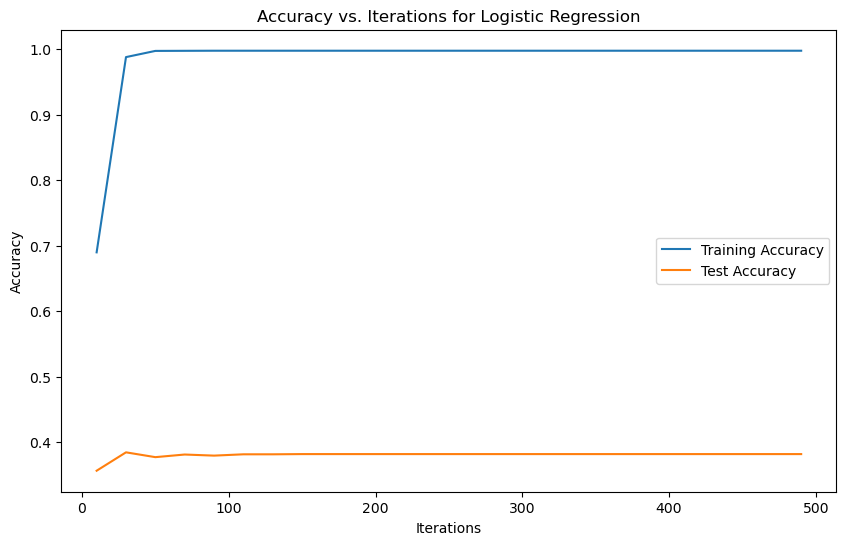

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to train and evaluate the model
def train_eval_logistic_regression(X_train, y_train, X_test, y_test, max_iter):
    model = LogisticRegression(max_iter=max_iter, solver='lbfgs')
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    return train_accuracy, test_accuracy

# Define the range of iterations (epochs)
iterations = range(10, 500, 20)

# Store the accuracies
train_accuracies = []
test_accuracies = []

for i in iterations:
    train_acc, test_acc = train_eval_logistic_regression(X_train_bow, training['cluster'], X_development_bow, development['cluster'], i)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_accuracies, label='Training Accuracy')
plt.plot(iterations, test_accuracies, label='Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for Logistic Regression')
plt.legend()
plt.show()


Second Iteration (With less feature)

In [37]:
from sklearn.model_selection import train_test_split
training, development = train_test_split(df, test_size=0.3, random_state=42)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, min_df=12)
training_text = training['processed_description']
development_text = development['processed_description']

X_train_bow = vectorizer.fit_transform(training_text)
X_development_bow = vectorizer.transform(development_text)

print('Number of unigram', len(vectorizer.get_feature_names_out()))

Number of unigram 5821


In [44]:
# Sum the counts of each bigram across all documents
unigram_counts = X_train_bow.sum(axis=0)
unigram_counts = np.array(unigram_counts).flatten()


# Get sorted indices based on counts (in descending order)
sorted_indices = unigram_counts.argsort()[::-1]

# Retrieve the top 10 unigram and their counts using the indices
top_10_unigram = [(vectorizer.get_feature_names_out()[i], unigram_counts[i]) for i in sorted_indices[:10]]

print("Top 10 unigram:")
for unigram, count in top_10_unigram:
    print(f"'{unigram}': {count}")

Top 10 unigram:
'one': 3046
'life': 3032
'world': 2321
'new': 2214
'year': 1965
'time': 1958
'love': 1803
'story': 1747
'find': 1604
'first': 1447


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_bow, training['cluster'])
training_target_pred = clf.predict(X_train_bow)
print(classification_report(training['cluster'], training_target_pred))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1304
           1       1.00      1.00      1.00       536
           2       0.99      1.00      0.99      1016
           3       1.00      1.00      1.00       963
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       489
           6       1.00      1.00      1.00        69
           7       1.00      0.98      0.99        52
           8       0.96      0.99      0.98       196
           9       1.00      1.00      1.00      2089
          10       1.00      0.97      0.98        98

    accuracy                           1.00      6979
   macro avg       1.00      0.99      0.99      6979
weighted avg       1.00      1.00      1.00      6979



In [48]:
development_target_pred = clf.predict(X_development_bow)
print(classification_report(development['cluster'], development_target_pred))
print(accuracy_score(development['cluster'], development_target_pred))

              precision    recall  f1-score   support

           0       0.38      0.42      0.40       536
           1       0.31      0.18      0.23       240
           2       0.32      0.32      0.32       423
           3       0.39      0.37      0.38       416
           4       0.44      0.15      0.22        81
           5       0.34      0.18      0.24       227
           6       0.87      0.90      0.88        29
           7       1.00      0.95      0.97        19
           8       0.70      0.87      0.77        90
           9       0.36      0.47      0.40       865
          10       0.33      0.11      0.16        66

    accuracy                           0.38      2992
   macro avg       0.50      0.45      0.45      2992
weighted avg       0.38      0.38      0.37      2992

0.38168449197860965
